# Red Sox Game Analysis

This file examines post-game entries at Kenmore station in comparison to expectations.

## Setup    

In [2]:
# Libraries.
import datetime as dt
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Feature libraries.
from features import date

In [3]:
# Package settings.

# Matplotlib.
%matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

In [65]:
# Other settings.

# Stations near Fenway for analysis. Fenway station itself is not in the gatecount dataset.
# Just use names (not locationid) as a surrogate key for station name.
fenway_stations = ['Kenmore Square', 'Hynes']

# Base units of timedeltas.
timedelta_base = 3.6e12

# Default figure size.
default_figsize = (12,8)

# Day of week mapping.
days_of_week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

## Data

### Read

In [5]:
# Read Red Sox home games.
sox = pd.DataFrame.from_csv("../../../data/sox_master.csv").reset_index(drop=True)

# Rename other columns to make joining easy.
sox.rename(columns={'START_DATE':'game_date', 'START_TIME':'game_time', 'OPPONENT':'opponent'}, inplace=True)

# Drop 0s from start date.
sox.game_date = sox.game_date.str.extract('(\d+-\d+-\d+)')
# Column for start datetime.
sox['game_datetime'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time)

# Add a "rounded" game time to make grouping easier.
sox['game_time_rounded'] = sox.game_time.str.replace(':[012][05] ',':00 ').str.replace(':[345][05] ',':30 ')
sox['game_datetime_rounded'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time_rounded)

# Turn start date into a date.
sox.game_date = pd.to_datetime(sox.game_date)

# Convert time fields to times.
sox.game_time = pd.DatetimeIndex(sox.game_datetime).time
sox.game_time_rounded = pd.DatetimeIndex(sox.game_datetime_rounded).time

In [ ]:
sox.head()

In [7]:
# Import gatecount data.
def get_data():
    return pd.DataFrame.from_csv("../../../data/mbta.csv").reset_index()
gatecount = date.init(get_data())

# Restrict to desired stations and the columns that we need.
fenway_gatecount = gatecount.ix[gatecount.name.isin(fenway_stations),['locationid','name','service_day','service_datetime','entries']].reset_index(drop=True)

# Turn days/dates into datetimes.
fenway_gatecount.service_day = pd.to_datetime(fenway_gatecount.service_day)
fenway_gatecount.service_datetime = pd.to_datetime(fenway_gatecount.service_datetime)

# Get time of day.
fenway_gatecount['service_time'] = pd.DatetimeIndex(fenway_gatecount.service_datetime).time

# Add day of week.
fenway_gatecount = date.add_day_of_week(fenway_gatecount.copy())

In [ ]:
fenway_gatecount.head()

### Merge

In [13]:
# Perform merge.
fenway_games = fenway_gatecount.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
fenway_games['game_played'] = (fenway_games.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
fenway_games['time_since_game_start'] = fenway_games.service_datetime - fenway_games.game_datetime_rounded

# Separate into classes: weekday/weekend and early/late.
fenway_games['day_of_week_class'] = 'Weekday'
fenway_games.ix[fenway_games.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
fenway_games['game_time_class'] = 'Early'
fenway_games.ix[fenway_games.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

In [ ]:
fenway_games[fenway_games.game_played].head()

## Game Exploration 

Let's figure out when games happen.

In [28]:
# Copy DF for this analysis.
sox_only = sox.copy()
# Add weekday.
sox_only['day_of_week'] = pd.DatetimeIndex(sox_only.game_date).weekday

# Also re-add some of the merged features from above.

# Separate into classes: weekday/weekend and early/late.
sox_only['day_of_week_class'] = 'Weekday'
sox_only.ix[sox_only.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
sox_only['game_time_class'] = 'Early'
sox_only.ix[sox_only.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

When do games occur during the week? **Monday is 0.**

In [29]:
games_by_dow = sox_only.groupby(['day_of_week']).agg({'game_time':len})
games_by_dow.columns = ['games']
games_by_dow

,games
day_of_week,
0,25
1,38
2,38
3,29
4,36
5,45
6,40


Answer: pretty consistently throughout the week. Slightly more on weekends, Tuesday, and Wednesday.

What about during the day?

In [30]:
# Group and aggregate by time.
games_by_time = sox_only.groupby(['game_time']).agg({'opponent':len})
games_by_time.columns = ['games']
# Sort and handle am/pm oddness.
games_by_time.sort(inplace=True)
games_by_time = games_by_time.ix[-2:,:].append(games_by_time.ix[:-2,:]) 
games_by_time

,games
game_time,
20:00:00,4
20:05:00,6
11:05:00,3
12:35:00,1
13:05:00,7
13:10:00,3
13:35:00,44
14:05:00,3
15:00:00,1


In [31]:
# Group and aggregate by rounded time.
games_by_time_rounded = sox_only.groupby(['game_time_rounded']).agg({'opponent':len})
games_by_time_rounded.columns = ['games']
# Sort and handle am/pm oddness.
games_by_time_rounded.sort(inplace=True)
games_by_time_rounded = games_by_time_rounded.ix[-2:,:].append(games_by_time_rounded.ix[:-2,:]) 
games_by_time_rounded

,games
game_time_rounded,
19:30:00,3
20:00:00,10
11:00:00,3
12:30:00,1
13:00:00,10
13:30:00,44
14:00:00,3
15:00:00,2
16:00:00,14


Now both. Use rounded time to cut down on volume.

In [32]:
# Group and aggregate by rounded time.
games_by_datetime = sox_only.groupby(['day_of_week','game_time_rounded']).agg({'opponent':len})
games_by_datetime.columns = ['games']
games_by_datetime

games
day_of_week game_time_rounded       
0           11:00:00               3
            13:30:00               3
            14:00:00               1
            18:00:00               1
            18:30:00               1
            19:00:00              16
1           13:00:00               1
            16:00:00               1
            18:00:00               1
            18:30:00               1
            19:00:00              33
            20:00:00               1
2           13:30:00               4
            16:00:00               3
            19:00:00              29
            19:30:00               2
3           13:00:00               1
            13:30:00               1
            16:00:00               2
            18:30:00               1
            19:00:00              23
            19:30:00               1
4           14:00:00               2
            15:00:00               2
            19:00:00              32
5           12:30:00               1
            13:00:00               8
            13:30:00               5
            16:00:00               8
            17:30:00               1
            19:00:00              20
            20:00:00               2
6           13:30:00              31
            19:00:00               2
            20:00:00               7

Primetime games are common throughout, except for Sunday. Instead, Sunday features a lot of early afternoon games. As expected, weekdays don't show many afternoon games, though Friday shows more than other weekdays (at various times). It looks like primetime games Monday-Saturday and Sunday afternoon games show the highest potential.

In [78]:
# One more: group and aggregate by rounded time.
games_by_datetime = sox_only.groupby(['day_of_week_class','game_time_class']).agg({'opponent':len})
games_by_datetime.columns = ['games']
games_by_datetime

games
day_of_week_class game_time_class       
Weekday           Early               24
                  Late               142
Weekend           Early               54
                  Late                31

## Game/Entries Exploration

### Aggregate

For exploratory purposes, let's compare all entries in the aggregate when there are games. This is useless for prediction because of the aggregation across times and days of week. But it will:

1. Give us a good sense of the aggregate ridership changes around game times, especially as most games are of similar length;
2. Help us figure out how to manipulate data for these questions.

In [34]:
# Get hourly entries for all times of day on gameless days. Use name to indicate stations.
gameless_entries = fenway_games[fenway_games.game_played == False]
gameless_entries = gameless_entries.groupby(['name','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries.rename(columns={'entries':'mean_entries'}, inplace=True)

In [35]:
# Only consider entries at the time of or soon after the game.
gametime_condition = (fenway_games.time_since_game_start >= np.timedelta64(-30,'m')) & (fenway_games.time_since_game_start <= np.timedelta64(6,'h'))
game_entries = fenway_games[fenway_games.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences = game_entries.merge(gameless_entries, on=['name','service_time'])[['name','entries','time_since_game_start','mean_entries']]
entry_differences['entries_vs_mean'] = entry_differences.entries - entry_differences.mean_entries
entry_differences['entries_vs_mean_ratio'] = entry_differences.entries / entry_differences.mean_entries

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences = entry_differences.groupby(['name','time_since_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std]
    }).reset_index()
mean_entry_differences.time_since_game_start = pd.to_timedelta(mean_entry_differences.time_since_game_start)
mean_entry_differences['hours_since_game_start'] = mean_entry_differences.time_since_game_start.astype(np.int) / timedelta_base

In [ ]:
mean_entry_differences

Kenmore Square mean increase in entries across time period: 4230
Hynes mean increase in entries across time period: 496


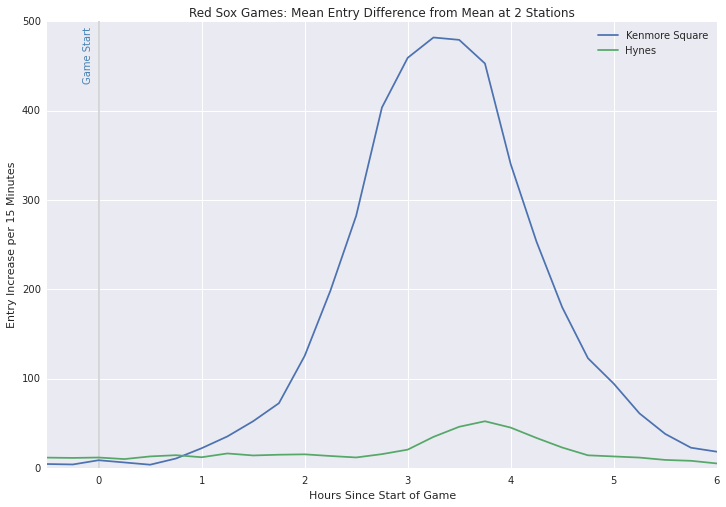

In [36]:
# Now plot them. Plot one line per station.

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
for station in fenway_stations:
    # Get station entries.
    station_entry_differences = mean_entry_differences[mean_entry_differences.name == station]
    plt.plot(station_entry_differences.hours_since_game_start, station_entry_differences.entries_vs_mean['mean'], label=station)
    # Add note about total over time range.
    print station+' mean increase in entries across time period:',int(station_entry_differences.entries_vs_mean['mean'].sum())
    
# Fix x limit and add origin lines.
xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
plt.vlines(0, *ylim, colors='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean at %d Stations' % len(fenway_stations))
plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)
plt.legend()

# Show.
plt.show()

In [113]:
# For added context, sum the mean difference for all stations.
print 'Mean increase in entries across time period for all stations:',int(mean_entry_differences.entries_vs_mean['mean'].sum())

Mean increase in entries across time period for all stations: 4726
Standard deviation: 139.21354208


Thus, on average we see a mean aggregate increase of **4,726** entries at Kenmore and Hynes from 30 minutes before the game until 6 hours after.

Next, show bands at one SD below and above.

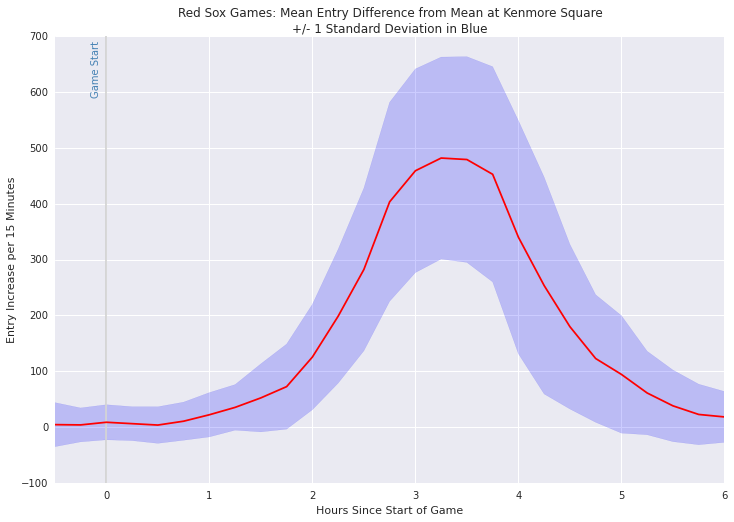

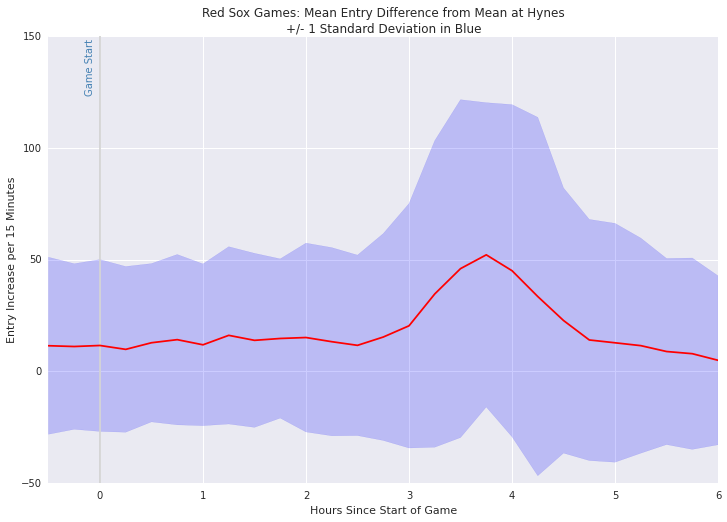

In [38]:
# Plot once per station.
for station in fenway_stations:
    # Get station entries and upper/lower bounds. Follows Fil's examples in GateCount_exploratory_fil.
    station_entry_differences = mean_entry_differences[mean_entry_differences.name == station]
    upper = station_entry_differences.entries_vs_mean['mean'] - station_entry_differences.entries_vs_mean['std']
    lower = station_entry_differences.entries_vs_mean['mean'] + station_entry_differences.entries_vs_mean['std']

    # Start plotting.
    plt.figure(figsize=default_figsize)
    plt.plot(station_entry_differences.hours_since_game_start, station_entry_differences.entries_vs_mean['mean'], 'r')
    plt.fill_between(station_entry_differences.hours_since_game_start, upper, lower, color='b', alpha=0.2)
    
    # Fix x limit and add origin lines.
    xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
    plt.vlines(0, *ylim, colors='lightgray')
    # plt.hlines(0, *xlim, colors='lightgray')
    plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

    # Prettify.
    plt.title('Red Sox Games: Mean Entry Difference from Mean at '+station+'\n+/- 1 Standard Deviation in Blue')
    plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
    plt.ylim(ylim)

    # Show.
    plt.show()

Below, we plot proportional change.

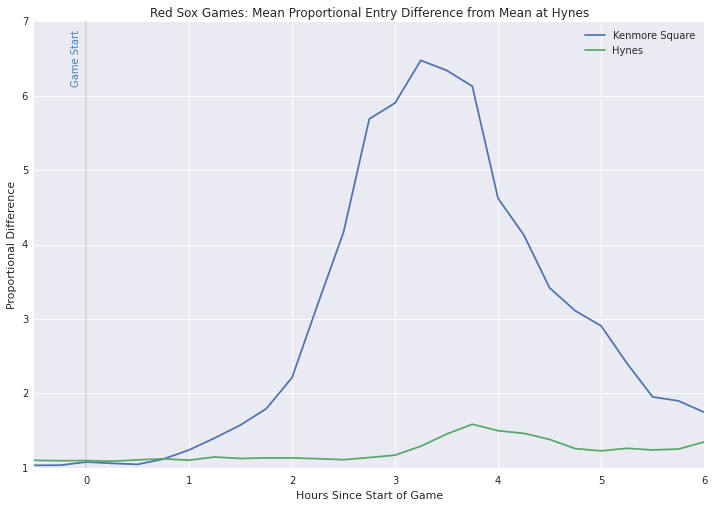

In [39]:
# Now plot them. Plot one line per station.

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
for station in fenway_stations:
    # Get station entries.
    station_entry_differences = mean_entry_differences[mean_entry_differences.name == station]
    plt.plot(station_entry_differences.hours_since_game_start, station_entry_differences.entries_vs_mean_ratio['mean'], label=station)
    
# Fix x limit and add origin lines.
xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
plt.vlines(0, *ylim, colors='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Prettify.
plt.title('Red Sox Games: Mean Proportional Entry Difference from Mean at '+station)
plt.xlabel('Hours Since Start of Game'); plt.ylabel('Proportional Difference')
plt.ylim(ylim)
plt.legend()

# Show.
plt.show()

It looks like very few people go to Hynes after games, but they still make up a decently sized proportion of postgame ridership compared to Kenmore.

### Specific Game Times

Let's go beyond aggregate games and consider more specific starting times. This is useful because it aligns with how we might model daily entries, and how planners might accommodate specific games. To maximize utility, we'll analyze 7:00pm games on Monday-Saturday, and 1:30pm games on Sunday.

In [40]:
# Store games to analyze.
day_time_pairs = [(d,dt.time(19)) for d in xrange(6)]
day_time_pairs.append((6,dt.time(13,30)))

In [41]:
# Get hourly entries for all days and times of day on gameless days. Use name to indicate stations.
gameless_entries_dow = fenway_games[fenway_games.game_played == False]
gameless_entries_dow = gameless_entries_dow.groupby(['name','day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_dow.rename(columns={'entries':'mean_entries'}, inplace=True)

In [42]:
# Only consider entries at the time of or soon after the game.
gametime_condition = (fenway_games.time_since_game_start >= np.timedelta64(-30,'m')) & (fenway_games.time_since_game_start <= np.timedelta64(6,'h'))
# We also need to set up a condition for day of week and game time.
game_day_time_condition = pd.Series([False]*len(fenway_games))
for d,t in day_time_pairs:
    game_day_time_condition = game_day_time_condition | ((fenway_games.day_of_week == d) & (fenway_games.game_time_rounded == t))# Filter games.
# Apply above conditions and ONLY CONSIDER KENMORE FOR NOW.
game_entries_dow = fenway_games[fenway_games.game_played & gametime_condition & game_day_time_condition & (fenway_games.name == 'Kenmore Square')]

# Join mean entries for gameless days at that time of day.
entry_differences_dow = game_entries_dow.merge(gameless_entries_dow, on=['name','day_of_week','service_time'])[['name','day_of_week','game_time_rounded','entries','time_since_game_start','mean_entries']]
entry_differences_dow['entries_vs_mean'] = entry_differences_dow.entries - entry_differences_dow.mean_entries
entry_differences_dow['entries_vs_mean_ratio'] = entry_differences_dow.entries / entry_differences_dow.mean_entries

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences_dow = entry_differences_dow.groupby(['name','day_of_week','game_time_rounded','time_since_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std]
    }).reset_index()
mean_entry_differences_dow.time_since_game_start = pd.to_timedelta(mean_entry_differences_dow.time_since_game_start)
mean_entry_differences_dow['hours_since_game_start'] = mean_entry_differences_dow.time_since_game_start.astype(np.int) / timedelta_base

In [ ]:
mean_entry_differences_dow

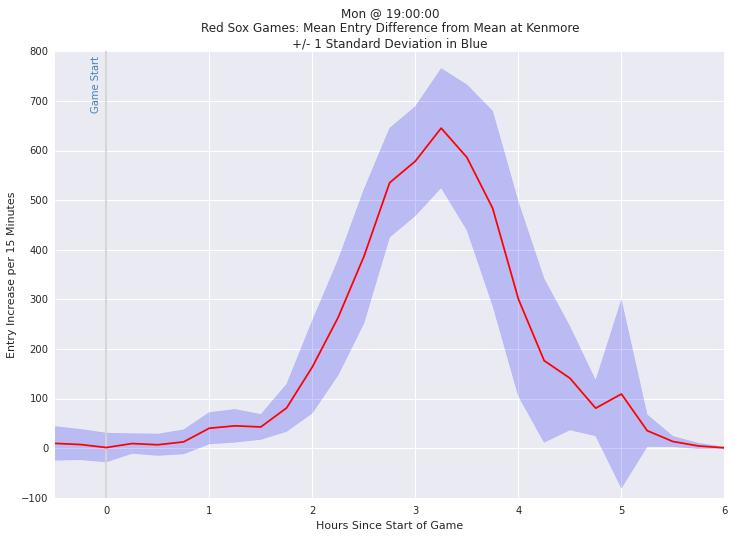

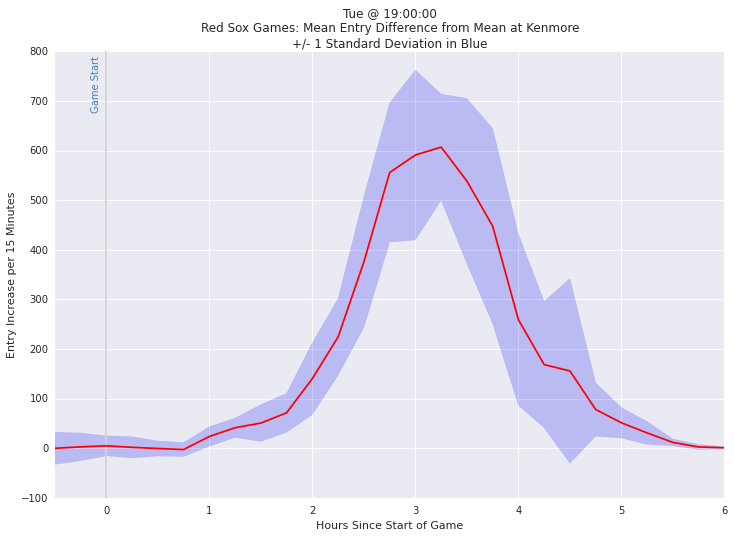

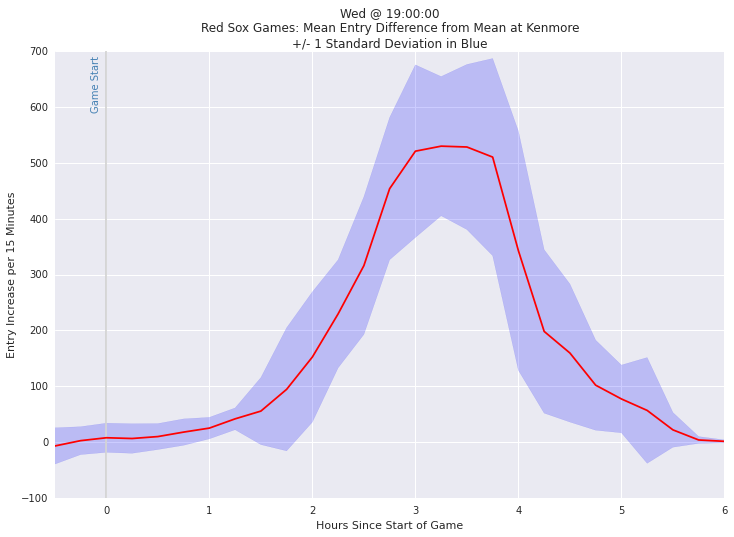

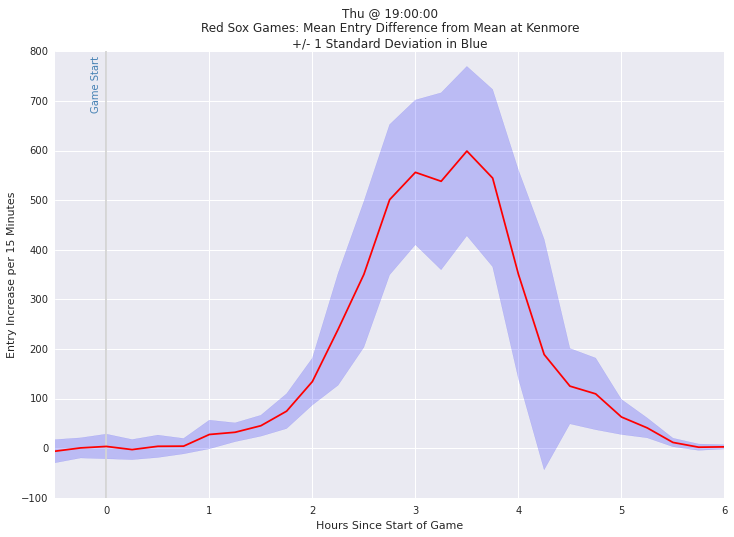

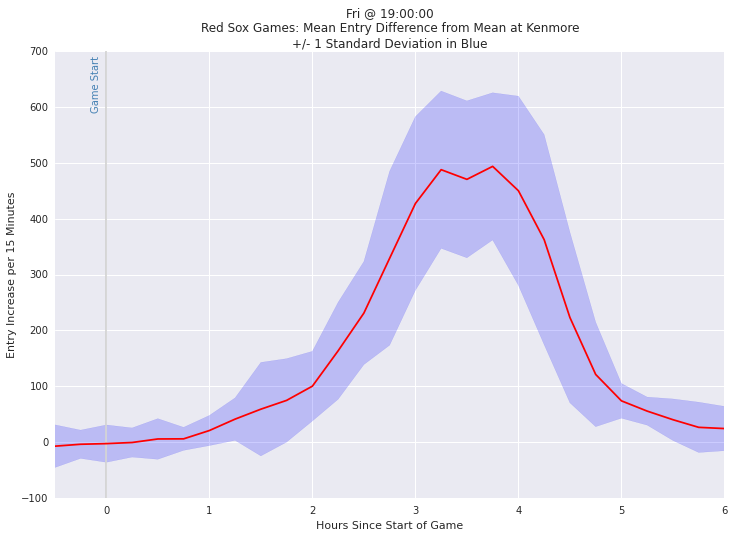

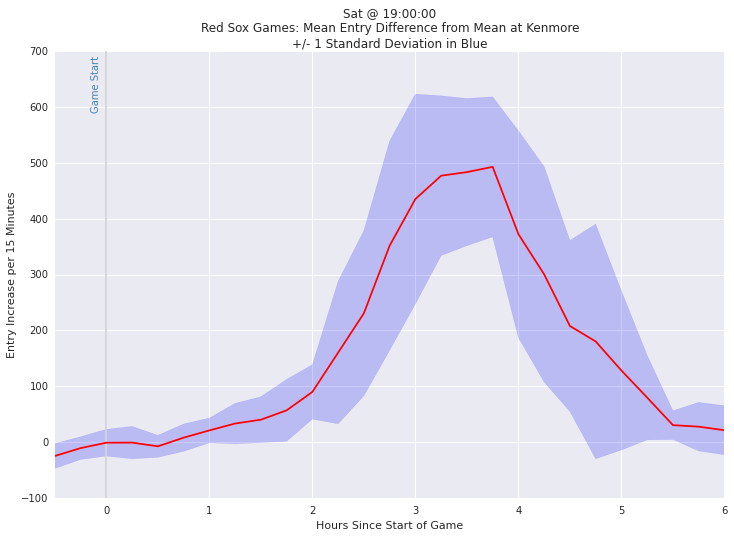

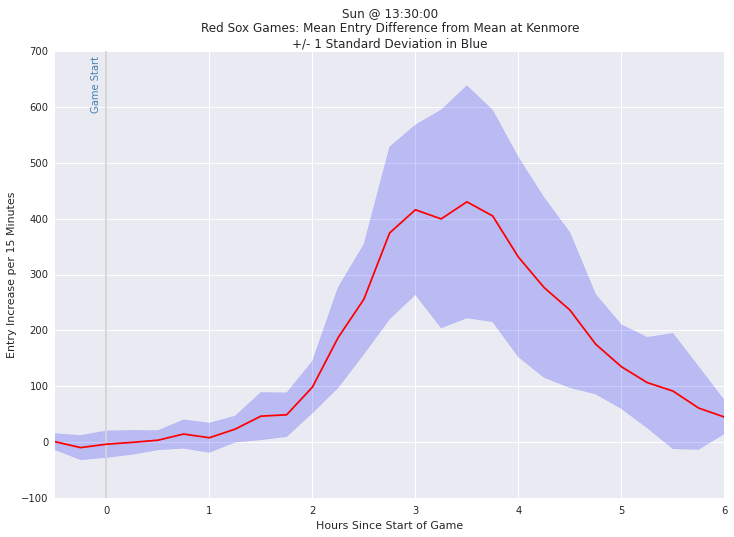

In [109]:
# Plot once per day of week.
for d,t in day_time_pairs:
    # Get station entries and upper/lower bounds. Follows Fil's examples in GateCount_exploratory_fil.
    game_dow_time_entry_differences = mean_entry_differences_dow[(mean_entry_differences_dow.day_of_week == d) & (mean_entry_differences_dow.game_time_rounded == t)]
    upper = game_dow_time_entry_differences.entries_vs_mean['mean'] - game_dow_time_entry_differences.entries_vs_mean['std']
    lower = game_dow_time_entry_differences.entries_vs_mean['mean'] + game_dow_time_entry_differences.entries_vs_mean['std']

    # Start plotting.
    plt.figure(figsize=default_figsize)
    plt.plot(game_dow_time_entry_differences.hours_since_game_start, game_dow_time_entry_differences.entries_vs_mean['mean'], 'r')
    plt.fill_between(game_dow_time_entry_differences.hours_since_game_start, upper, lower, color='b', alpha=0.2)
    
    # Fix x limit and add origin lines.
    xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
    plt.vlines(0, *ylim, colors='lightgray')
    # plt.hlines(0, *xlim, colors='lightgray')
    plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

    # Prettify.
    plt.title(days_of_week[d]+' @ '+str(t)+'\nRed Sox Games: Mean Entry Difference from Mean at Kenmore\n+/- 1 Standard Deviation in Blue')
    plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
    # plt.ylim(ylim)

    # Show.
    plt.show()

### Aggregate Distribution

Now let's calculate the distribution of additional entries per game. Each observation is a *game* in this case, and each measurement is the sum of entries above mean over the 6.5 hour period above.

In [110]:
# We can reuse some tables from above. game_entries_dow will suit our needs but we'll need to derive another df for games.

# Only consider entries at the time of or soon after the game.
gametime_condition = (fenway_games.time_since_game_start >= np.timedelta64(-30,'m')) & (fenway_games.time_since_game_start <= np.timedelta64(6,'h'))
all_games_entries = fenway_games[fenway_games.game_played & gametime_condition]

# Get differences from means.
entry_differences_fields = ['game_date','day_of_week_class','game_time_class','entries','mean_entries']
entry_differences_class = all_games_entries.merge(gameless_entries_dow, on=['name','day_of_week','service_time'])[entry_differences_fields]
entry_differences_class['entries_vs_mean'] = entry_differences_class.entries - entry_differences_class.mean_entries

# Now aggregate by game and class, and sum entries vs. mean.
agg_entry_differences = entry_differences_class.groupby(['game_date','day_of_week_class','game_time_class']).agg({'entries_vs_mean': np.sum}).reset_index()

# Generate a new class field for grouping.
agg_entry_differences['game_class'] = agg_entry_differences.day_of_week_class + ' ' + agg_entry_differences.game_time_class

# Get classes to plot.
game_classes = set(agg_entry_differences.game_class)

In [88]:
agg_entry_differences.head()

,game_date,day_of_week_class,game_time_class,entries_vs_mean,game_class
0,2013-04-08,Weekday,Early,6606.180851,Weekday Early
1,2013-04-10,Weekday,Late,6438.801469,Weekday Late
2,2013-04-11,Weekday,Late,4850.871540,Weekday Late
3,2013-04-13,Weekend,Early,9464.415727,Weekend Early
4,2013-04-14,Weekend,Early,9099.222892,Weekend Early


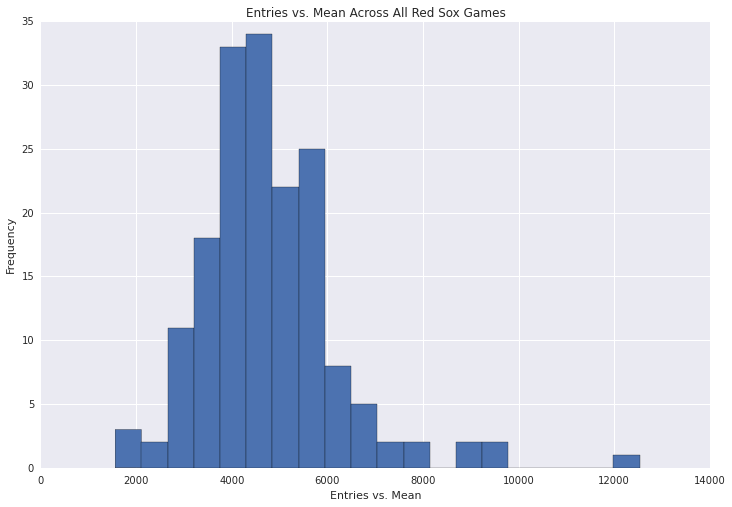

In [118]:
# Start plotting.
plt.figure(figsize=default_figsize)
plt.hist(agg_entry_differences.entries_vs_mean, bins=20)
# Prettify.
plt.title('Entries vs. Mean Across All Red Sox Games')
plt.xlabel('Entries vs. Mean'); plt.ylabel('Frequency')
# Show.
plt.show()

In [124]:
agg_entry_differences.sort(columns='entries_vs_mean', ascending=False).head()

,game_date,day_of_week_class,game_time_class,entries_vs_mean,game_class
98,2014-04-21,Weekday,Early,12525.987188,Weekday Early
96,2014-04-19,Weekend,Early,9684.409877,Weekend Early
3,2013-04-13,Weekend,Early,9464.415727,Weekend Early
4,2013-04-14,Weekend,Early,9099.222892,Weekend Early
89,2014-04-04,Weekday,Early,8777.179265,Weekday Early


Looks like Patriots Day last year is the big outlier. Lots of other April games in the top tier—this could be picking up on a seasonal effect rather than truly significant games.